In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from keras import models,layers
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.externals import joblib
import xgboost as xgb
import os
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#import preparation,evaluation,logistic,SVC,naive,randomForest,XGboost,ADAboost,NeuralNet,result

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 評価関数
# neg_mean_squared_error
# r2
score = 'neg_mean_squared_error'


# アルゴリズム
# lasso
# SVR
# randomForest
# xgboost
# adaboost
# neuralNet

arg = ['lasso','randomForest','xgboost','adaboost','neuralNet']

Using TensorFlow backend.


In [8]:
# 文字列をカテゴリカルに
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))


In [9]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000


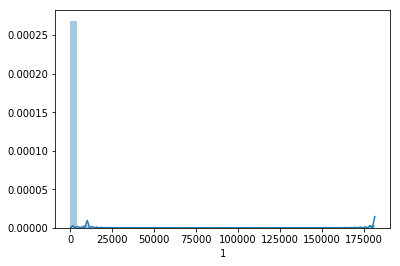

In [7]:
# 目的変数が正規分布か調べる
ax = sns.distplot(train.iloc[1])
plt.show()

In [150]:
# 目的変数を正規分布に近づけてpreparation用に整える
train = pd.concat([pd.DataFrame(train['Id']),pd.DataFrame(np.log(train['SalePrice'])),train.drop(['Id','SalePrice'],axis=1)],axis=1)

In [151]:
train_x, train_y, test, test_ID = preparation(train, test)

C:\Users\fujii\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Training done using Random Forest


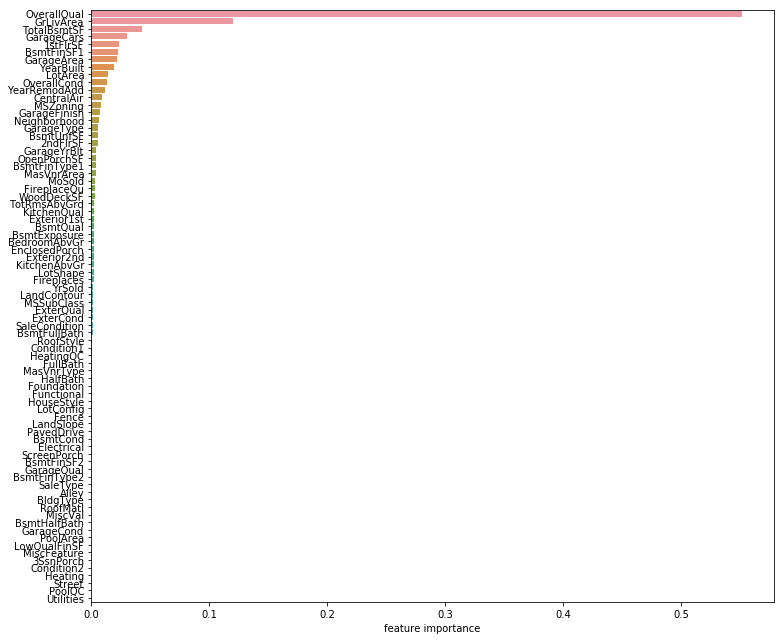

In [152]:
# 重要な特徴量を調べる
# この処理までに欠損値とobject変数をなくす
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(train_x, train_y)
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=train_x.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [154]:
a = train_x.columns.values[ranking][0]
b = train_x.columns.values[ranking][1]

# use the top 30 features only
train_x = train_x.iloc[:,ranking[:30]]
test = test.iloc[:,ranking[:30]]

# interaction between the top 2
train_x["Interaction"] = train_x[a]*train_x[b]
test["Interaction"] = test[a]*test[b]

In [137]:
types = pd.DataFrame(train_x.dtypes).rename(columns={0: 'type'}).sort_values(by=['type'],ascending=False)

# 型、欠損値の数、欠損値の％、特徴の種類の数
def check_missing(df):
    null_val = df.isnull().sum()
    unique = df.nunique()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent, unique], axis=1)
    col = missing_table.rename(columns = {0 : 'NoneNum', 1: 'Rate' ,2 : 'unique'})
    return col

# Display columns missing values are under 1%.
print("Data #"+str(len(train_x)))
cols = check_missing(train_x)

types.join(cols).sort_values(by="Rate", ascending=False)

Data #1371


,type,NoneNum,Rate,unique
GarageYrBlt,float64,0,0.0,97
FullBath,int64,0,0.0,4
1stFlrSF,int64,0,0.0,734
YearBuilt,int64,0,0.0,109
OverallCond,int64,0,0.0,8
MSZoning,int64,0,0.0,5
LotArea,int64,0,0.0,1014
YearRemodAdd,int64,0,0.0,61
CentralAir,int64,0,0.0,2
2ndFlrSF,int64,0,0.0,398


In [178]:
score = 'neg_mean_squared_error'
arg = ['neuralNet']

# 正規化
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test = scaler.fit_transform(test)

#　アルゴリズムの結果を格納するリスト
ranking = {}

ranking = evaluation(train_x, train_y, ranking, arg)

# アルゴリズムをランキング形式で並べ替え
ranking = sorted(ranking.items(), key=lambda x:-x[1])

# 結果
result(train_x, train_y, test, test_ID, score, ranking)

C:\Users\fujii\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


412/412 [==============================] - 0s 682us/step
評価指標：neg_mean_squared_error

アルゴリズムランキング
1位：ニューラルネット（2.123527769903535）
Train on 959 samples, validate on 412 samples
Epoch 1/20
959/959 [==============================] - 1s 1ms/step - loss: 125.9658 - mean_squared_error: 125.9658 - val_loss: 108.2367 - val_mean_squared_error: 108.2367
Epoch 2/20
959/959 [==============================] - 0s 33us/step - loss: 97.7115 - mean_squared_error: 97.7115 - val_loss: 82.8420 - val_mean_squared_error: 82.8420
Epoch 3/20
959/959 [==============================] - 0s 33us/step - loss: 73.5078 - mean_squared_error: 73.5078 - val_loss: 59.9411 - val_mean_squared_error: 59.9411
Epoch 4/20
959/959 [==============================] - 0s 33us/step - loss: 51.9160 - mean_squared_error: 51.9160 - val_loss: 41.3299 - val_mean_squared_error: 41.3299
Epoch 5/20
959/959 [==============================] - 0s 33us/step - loss: 35.4951 - mean_squared_error: 35.4951 - val_loss: 28.4299 - val_mean_squared_er

In [74]:
def preparation(train, test):
    
    # trainとtestを結合する前に判別フラグを立てる
    train['train_flg'] = 1
    test['train_flg'] = 0
    
    # testに答えの列を追加
    test[train.columns[1]] = 9
    
    # trainとtestを結合
    train_test_combine = pd.concat([train,test],axis=0)

    # 削除する行名と列名の格納するリストを定義
    delete_row = []
    delete_column = []

    # 欠損値の割合を計算
    percent = 100 * train_test_combine.isnull().sum()/ len(train_test_combine)      

    # 特徴量の数だけループ
    for i in range(percent.size):
        # object型かつカラムに30種類以上のデータが含まれる、または、欠損値が全体の15％以上ある場合列を削除
        if (train_test_combine[percent.index[i]].dtype == ('object') 
        and train_test_combine[percent.index[i]].nunique() >= 30)or percent[i] >= 15:
            delete_column.append(percent.index[i])
        # 欠損値が存在し、全体の15％以下である場合行を削除
        elif percent[i] > 0 and percent[i] < 15:
            delete_row.append(percent.index[i])
    
    # 行の削除
    for i in delete_row:
        train_test_combine = train_test_combine[train_test_combine[i].notnull()]
    # 列の削除
    for j in delete_column:
        train_test_combine = train_test_combine.drop([j], axis=1)
        
    # trainの答えを退避
    train_y = train_test_combine[train_test_combine['train_flg'] == 1][train.columns[1]]
    # testのIDを退避
    test_ID = train_test_combine[train_test_combine['train_flg'] == 0][test.columns[0]]
    
    # ID, 答えを削除
    train_test_combine = train_test_combine.drop([train.columns[0],train.columns[1]],axis=1) 
    
    # カテゴリカル変数の特徴量だけを抽出
    categorical_columns = [c for c in train_test_combine.columns if (train_test_combine[c].dtype != ('float64') and train_test_combine[c].dtype != ('int64') and train_test_combine[c].dtype != ('bool'))]

    # カテゴリカル変数の種類と個数を出力し、one-hot-encoding
    for col in categorical_columns:
        ohe = pd.get_dummies(train_test_combine[col],drop_first=True)
        train_test_combine = train_test_combine.drop([col],axis=1)
        train_test_combine = pd.concat([train_test_combine,ohe], axis=1)
        
    train = train_test_combine[train_test_combine['train_flg'] == 1].drop(['train_flg'], axis=1)
    test = train_test_combine[train_test_combine['train_flg'] == 0].drop(['train_flg'], axis=1)
    
    return train, train_y, test, test_ID

In [125]:
def evaluation(x, y, ranking, arg):

    for i in arg:
        if i == 'lasso':
            ranking = lasso(x, y, ranking)
        elif i == 'SVR':
            ranking = SVReg(x, y, ranking)
        elif i == 'randomForest':
            ranking = randomForest(x, y, ranking)
        elif i == 'xgboost':
            ranking = XGboost(x, y, ranking)
        elif i == 'adaboost':
            ranking = ADAboost(x, y, ranking)
        elif i == 'neuralNet':
            ranking = NeuralNet(x, y, ranking)
        else:
            print(i + 'は対応していません')
    
    return ranking

In [119]:
def lasso(x, y, ranking):
    #ラッソ線形回帰

    lassoreg = Lasso(alpha=0.5)
    answer = cross_val_score(lassoreg, x, y, scoring = score)
    ranking['ラッソ回帰'] = np.average(answer)
    return ranking

In [145]:
def SVReg(x, y, ranking):
    #サポートベクトルマシン

    svr = SVR(C=1.0,kernel='rbf', gamma=0.1)
    answer = cross_val_score(svr, x, y, scoring = score)
    ranking['サポートベクトルリグレッサー'] = np.average(answer)
    return ranking

In [159]:
def randomForest(x, y, ranking):
    #ランダムフォレスト

    RF = RandomForestRegressor(n_estimators=25, random_state=0, n_jobs=-1)
    answer = cross_val_score(RF, x, y, scoring = score)
    ranking['ランダムフォレスト'] = np.average(answer)
    return ranking

In [122]:
def XGboost(x, y, ranking):
    #Xgboost

    xgboost = xgb.XGBRegressor(max_depth=4, n_estimators=100,random_state=0)
    answer = cross_val_score(xgboost, x, y, scoring = score)
    ranking['XGブースト'] = np.average(answer)
    return ranking

In [123]:
def ADAboost(x, y, ranking):
    #ADAブースト

    adaboost = AdaBoostRegressor(random_state=0)
    answer = cross_val_score(adaboost, x, y, scoring =score)
    ranking['ADAブースト'] = np.average(answer)
    return ranking

In [124]:
def NeuralNet(x, y, ranking):
    # ニューラルネット

    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=0.3, random_state=0)

    model = models.Sequential()
    model.add(layers.Dense(units=32, activation='relu', input_shape=(X_train[0].size,)))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=1))
    model.compile(loss="mse", optimizer = "rmsprop", metrics=["mse"])

    # 早期終了を行うコールバック関数を設定
    callbacks = [EarlyStopping(monitor="val_loss", patience=2)]

    history = model.fit(X_train, y_train, epochs=20, verbose=1, callbacks = callbacks, batch_size=100) 
    loss, scores = model.evaluate(X_test, y_test)

    ranking['ニューラルネット'] = scores
    return ranking

In [177]:
def result(x, y, xt, test_ID, score, ranking):

    print("評価指標：" + score)
    print()
    print("アルゴリズムランキング")
    j = 1

    for k, i in ranking:
        print(str(j) + "位：" + k,end="")
        print("（" ,end="")
        print(i, end="")
        print("）")
        if j == 1:
            if k == 'ニューラルネット':
                model = models.Sequential()
                model.add(layers.Dense(units=32, activation='relu', input_shape=(x[0].size,)))
                model.add(layers.Dense(units=64, activation='relu'))
                model.add(layers.Dropout(0.2))
                model.add(layers.Dense(units=1))
                callbacks = [EarlyStopping(monitor="val_loss", patience=2),
                             ModelCheckpoint(filepath = "best_model.h5",monitor = "val_loss", save_best_only = True)]
                model.compile(loss="mse", optimizer = "rmsprop", metrics=["mse"])
                model.fit(x, y, epochs=20, verbose=1, callbacks = callbacks, batch_size=100,validation_split=0.3) 
                predicted = model.predict(xt)
                submit= pd.concat([test_ID, pd.DataFrame(predicted)],axis = 1)
                if os.path.isfile('best_model.pkl'):
                    os.remove('best_model.pkl')
                
            else:
                if k == 'ラッソ回帰':
                    model = Lasso(alpha=0.5).fit(x,y)
                elif k == 'サポートベクトルリグレッサー':
                    model = SVR(C=1.0,kernel='rbf', gamma=0.1).fit(x,y)
                elif k == 'ランダムフォレスト':
                    model = RandomForestClassifier(n_estimators=25, random_state=0, n_jobs=-1).fit(x,y)
                elif k == 'XGブースト':
                    model = xgb.XGBRegressor().fit(x,y)
                elif k == 'ADAブースト':
                    model = AdaBoostClassifier(random_state=0).fit(x,y)


                joblib.dump(model, "best_model.pkl")
                predicted = model.predict(xt)
                submit = pd.concat([test_ID, pd.DataFrame(predicted)],axis = 1)
                if os.path.isfile('best_model.h5'):
                    os.remove('best_model.h5')

        j += 1

    submit.to_csv("submit.csv")